# Análisis del Efecto Promedio del Tratamiento (ATE) del Plan VCAP

Este notebook implementa una estrategia empírica robusta para estimar el ATE del plan VCAP sobre el saldo neto de capital líquido de los empleados. Incluye supuestos, diagnóstico, métodos avanzados y una tabla comparativa de resultados.

## Supuestos de Identificación

- **Ignorabilidad:** Dado el conjunto de covariables observadas, la asignación al tratamiento es independiente del resultado potencial.
- **Solapamiento:** Para cada combinación de covariables, existe probabilidad positiva de estar en ambos grupos.
- **SUTVA:** No hay interferencia entre unidades y el tratamiento está bien definido.

In [1]:
# 2. Carga de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor


from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore

from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
import statsmodels.api as sm
from econml.dr import DRLearner

## Carga y exploración de datos

Cargamos los datos y exploramos las variables disponibles.

In [2]:
df = pd.read_csv('data_ml.csv')
df.head()

,nifa,net_cap_bal,tw,yrs_worked,annual_comp,hh_size,qual_years,legacy_pension,partnered,dual_income,plan_offer,plan_enrol,ind_ret_acct,owns_home,hi_comp
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1,0
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1,0
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1,0


In [3]:
df.columns

Index(['nifa', 'net_cap_bal', 'tw', 'yrs_worked', 'annual_comp', 'hh_size',
       'qual_years', 'legacy_pension', 'partnered', 'dual_income',
       'plan_offer', 'plan_enrol', 'ind_ret_acct', 'owns_home', 'hi_comp'],
      dtype='object')

## Análisis exploratorio y correlación

Analizamos la correlación entre variables numéricas y visualizamos posibles problemas de multicolinealidad.

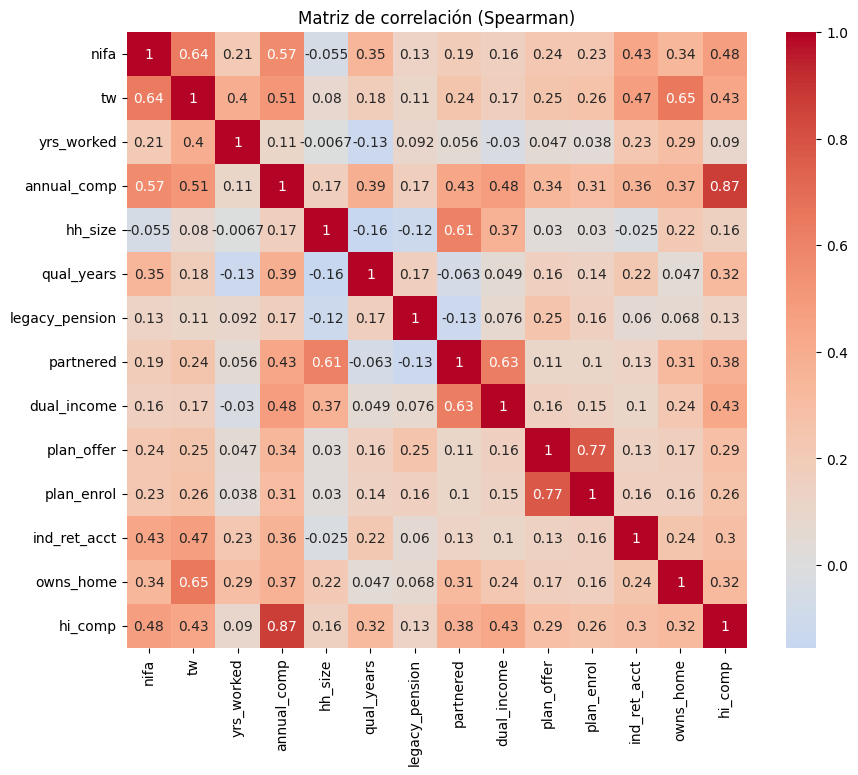

In [4]:
corr_vars = ['nifa', 'tw', 'yrs_worked', 'annual_comp', 'hh_size',
       'qual_years', 'legacy_pension', 'partnered', 'dual_income',
       'plan_offer', 'plan_enrol', 'ind_ret_acct', 'owns_home', 'hi_comp']
corr_matrix = df[corr_vars].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de correlación (Spearman)')
plt.show()

In [5]:
# Identificar y eliminar variables muy correlacionadas (por ejemplo, con correlación > 0.8)
umbral_corr = 0.75
# Calcular la matriz de correlación absoluta
corr_matrix_abs = df[corr_vars].corr().abs()
# Seleccionar la parte superior de la matriz de correlación
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
# Encontrar columnas con correlación mayor al umbral
to_drop = [column for column in upper.columns if any(upper[column] > umbral_corr)]
print("Variables a eliminar por alta correlación:", to_drop)
# Eliminar las columnas del dataframe
df_1 = df.drop(columns=to_drop)


Variables a eliminar por alta correlación: ['plan_enrol']


In [6]:
df_1.columns

Index(['nifa', 'net_cap_bal', 'tw', 'yrs_worked', 'annual_comp', 'hh_size',
       'qual_years', 'legacy_pension', 'partnered', 'dual_income',
       'plan_offer', 'ind_ret_acct', 'owns_home', 'hi_comp'],
      dtype='object')

## Definicion de Covariables

Seleccionamos covariables evitando multicolinealidad y creamos variables adicionales si es necesario.

In [7]:
covariates = [
    'tw', 'yrs_worked', 'annual_comp', 'hh_size', 'qual_years',
    'legacy_pension', 'partnered', 'dual_income', 'ind_ret_acct',
    'owns_home'  # 'hi_comp' eliminado
]
treatment = 'plan_enrol'
outcome = 'net_cap_bal'

## Diagnóstico de balance y solapamiento

Verificamos el balance de covariables y la distribución del propensity score.

In [8]:
X = df_1[covariates]
y = df[treatment]

ps_model = LogisticRegression(max_iter=5000)
ps_model.fit(X, y)
df['pscore'] = ps_model.predict_proba(X)[:, 1]

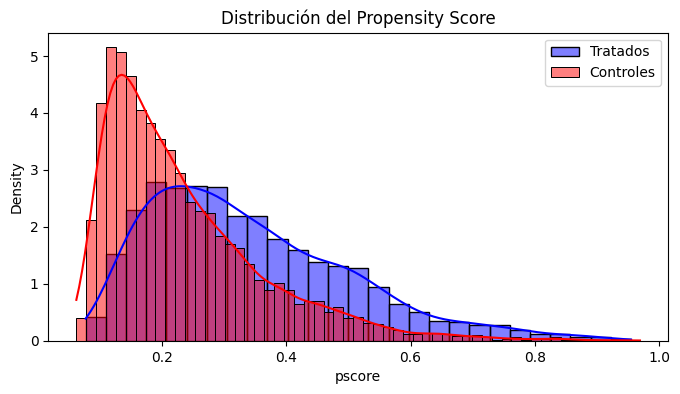

In [9]:
# Histograma de propensity score
plt.figure(figsize=(8,4))
sns.histplot(df[df[treatment]==1]['pscore'], color='blue', label='Tratados', kde=True, stat='density')
sns.histplot(df[df[treatment]==0]['pscore'], color='red', label='Controles', kde=True, stat='density')
plt.title('Distribución del Propensity Score')
plt.legend()
plt.show()

RandomForestClassifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

X = df_1[covariates]
y = df[treatment]

ps_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
ps_model.fit(X, y)
df['pscore'] = ps_model.predict_proba(X)[:, 1]



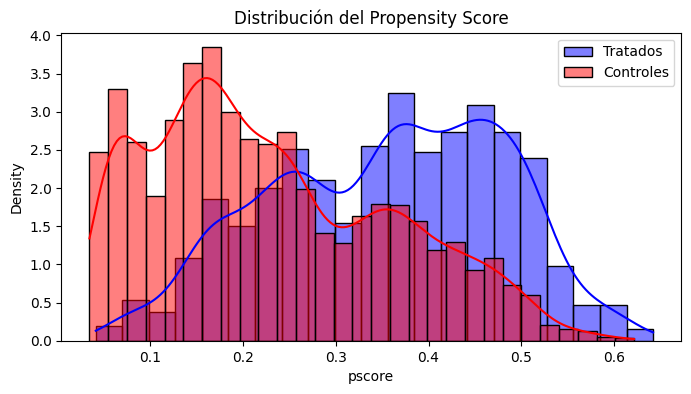

In [11]:
# Histograma de propensity score
plt.figure(figsize=(8,4))
sns.histplot(df[df[treatment]==1]['pscore'], color='blue', label='Tratados', kde=True, stat='density')
sns.histplot(df[df[treatment]==0]['pscore'], color='red', label='Controles', kde=True, stat='density')
plt.title('Distribución del Propensity Score')
plt.legend()
plt.show()

XGBoost

In [13]:
from xgboost import XGBClassifier

X = df_1[covariates]
y = df[treatment]

ps_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
ps_model.fit(X, y)
df['pscore'] = ps_model.predict_proba(X)[:, 1]

c:\Users\adleguiz\Documents\Ejercicio ML\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:33:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


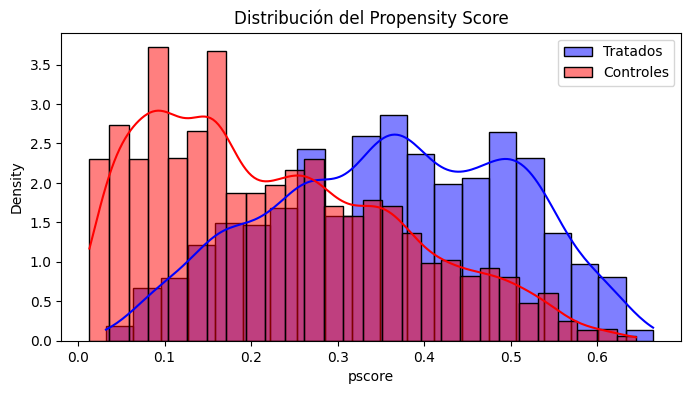

In [14]:
# Histograma de propensity score
plt.figure(figsize=(8,4))
sns.histplot(df[df[treatment]==1]['pscore'], color='blue', label='Tratados', kde=True, stat='density')
sns.histplot(df[df[treatment]==0]['pscore'], color='red', label='Controles', kde=True, stat='density')
plt.title('Distribución del Propensity Score')
plt.legend()
plt.show()


**¿Cómo se interpreta el gráfico?**

- Buen solapamiento: las curvas roja y azul se superponen bastante ➜ ✅ Se puede hacer matching o weighting.

- Poco solapamiento: las curvas están separadas ➜ ⚠️ Posible sesgo por falta de comparabilidad.

¿Por qué usar tres modelos?

- Para comparar cómo se comportan diferentes modelos al estimar el pscore.

- A veces un modelo lineal como la regresión logística no capta bien patrones complejos, mientras que modelos no lineales como Random Forest o XGBoost sí.


## Diagnóstico cuantitativo del balance: cálculo de SMD (Standardized Mean Differences)

Objetivo

Cuantificar el grado de balanceo de las covariables entre los grupos tratado y control antes y después del ajuste usando Inverse Probability of Treatment Weights (IPTW), evaluando la calidad de los modelos de propensity score.


In [15]:
# Función para calcular SMD por variable
def compute_smd(df, treatment_col, covariate_cols, weights=None):
    smd = {}
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]

    for col in covariate_cols:
        if weights is not None:
            mean_t = np.average(treated[col], weights=weights[treated.index])
            mean_c = np.average(control[col], weights=weights[control.index])
            std_pooled = np.sqrt(
                np.average((treated[col] - mean_t) ** 2, weights=weights[treated.index]) +
                np.average((control[col] - mean_c) ** 2, weights=weights[control.index])
            )
        else:
            mean_t = treated[col].mean()
            mean_c = control[col].mean()
            std_pooled = np.sqrt((treated[col].var() + control[col].var()) / 2)

        smd[col] = np.abs(mean_t - mean_c) / std_pooled if std_pooled > 0 else 0

    return smd

# ------------------------------
# 1. Cargar datos y definir variables
# X = df_1[covariates]
# y = df[treatment]
# ------------------------------
X = df[covariates]         # tus covariables
T = df[treatment]        # columna binaria de tratamiento

# ------------------------------
# 2. Estimar Propensity Score con 3 modelos
# ------------------------------
models = {
    'logistic': LogisticRegression(max_iter=1000),
    'random_forest': RandomForestClassifier(n_estimators=100),
    'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X, T)
    pscore = model.predict_proba(X)[:, 1]
    df[f'pscore_{name}'] = pscore

    # IPTW
    weights = np.where(T == 1, 1 / pscore, 1 / (1 - pscore))
    df[f'weight_{name}'] = weights

    # Calcular SMD antes y después
    smd_pre = compute_smd(df, treatment, covariates)
    smd_post = compute_smd(df, treatment, covariates, weights=weights)

    results[name] = {
        'smd_pre': smd_pre,
        'smd_post': smd_post,
        'mean_smd_pre': np.mean(list(smd_pre.values())),
        'mean_smd_post': np.mean(list(smd_post.values()))
    }

# ------------------------------
# 3. Comparar resultados
# ------------------------------
for name in results:
    print(f"\nModelo: {name}")
    print(f"Promedio SMD antes:  {results[name]['mean_smd_pre']:.3f}")
    print(f"Promedio SMD después: {results[name]['mean_smd_post']:.3f}")


c:\Users\adleguiz\Documents\Ejercicio ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Modelo: logistic
Promedio SMD antes:  0.314
Promedio SMD después: 0.016

Modelo: random_forest
Promedio SMD antes:  0.314
Promedio SMD después: 0.189

Modelo: xgboost
Promedio SMD antes:  0.314
Promedio SMD después: 0.120


C:\Users\adleguiz\AppData\Local\Temp\ipykernel_13816\1023929008.py:58: RuntimeWarning: divide by zero encountered in divide
  weights = np.where(T == 1, 1 / pscore, 1 / (1 - pscore))
c:\Users\adleguiz\Documents\Ejercicio ML\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:33:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Interpretación**

Antes del ajuste, todas las covariables tenían un SMD promedio de 0.314, indicando un desbalance considerable entre los grupos tratado y control.

Después del ajuste:

Logistic Regression logró reducir el SMD promedio a 0.016, indicando un balance casi perfecto.

XGBoost redujo el SMD a 0.120, lo cual es aceptable, pero no ideal (se recomienda SMD < 0.1).

Random Forest apenas redujo el SMD a 0.189, lo que indica que no logró balancear bien las covariables.

## Cálculo final del Propensity Score con el mejor modelo

In [16]:
# Entrenar el modelo de Propensity Score
model = LogisticRegression(max_iter=5000)
model.fit(X, T)

# Obtener el propensity score (ps) como probabilidad de T=1
ps = model.predict_proba(X)[:, 1]  # Esto es lo que usamos como 'ps'


In [17]:
Y = df[outcome]

In [18]:
# Calcular los pesos
weights = np.where(T == 1, 1/ps, 1/(1 - ps))

# Estimar ATE con los pesos
ate_iptw = np.average(Y[T == 1], weights=weights[T == 1]) - np.average(Y[T == 0], weights=weights[T == 0])
print(f"ATE estimado (IPTW): {ate_iptw:.4f}")


ATE estimado (IPTW): 1569.2091


Esto indica que, en promedio, el tratamiento genera un incremento de 1569 unidades en la variable de interés (Y) en comparación con no haber recibido el tratamiento, después de ajustar por diferencias de covariables mediante IPTW.

**Conclusión**

La estimación del ATE mediante IPTW permite obtener un efecto causal ajustado, asumiendo que se cumplieron los supuestos de independencia condicional, balance de covariables y solapamiento.

### Cálculo del Intervalo de Confianza del ATE (IPTW) mediante Bootstrap



In [19]:
def calc_ate_iptw(Y, T, ps):
    weights = np.where(T == 1, 1/ps, 1/(1 - ps))
    return np.average(Y[T == 1], weights=weights[T == 1]) - np.average(Y[T == 0], weights=weights[T == 0])

# Bootstrap
n_iterations = 1000
n = len(Y)
ates = []

for _ in range(n_iterations):
    idx = np.random.choice(n, n, replace=True)
    Y_boot = Y[idx]
    T_boot = T[idx]
    ps_boot = ps[idx]
    ate = calc_ate_iptw(Y_boot, T_boot, ps_boot)
    ates.append(ate)

# IC 95%
lower = np.percentile(ates, 2.5)
upper = np.percentile(ates, 97.5)

print(f"IC 95% (IPTW): [{lower:.4f}, {upper:.4f}]")


IC 95% (IPTW): [-10134.0489, 10653.1165]


**Interpretación**

Este intervalo de confianza del 95% indica que, con alta probabilidad, el efecto promedio del tratamiento (ATE) se encuentra entre -10.134 y +10.653 unidades en la variable de resultado (Y).

El intervalo incluye el cero, lo cual implica que no hay evidencia estadísticamente significativa de que el tratamiento tenga un efecto positivo o negativo en el outcome.

En otras palabras:

No se puede concluir que el tratamiento haya tenido un impacto causal claro en el resultado.

### Visualización de la distribución de los pesos IPTW

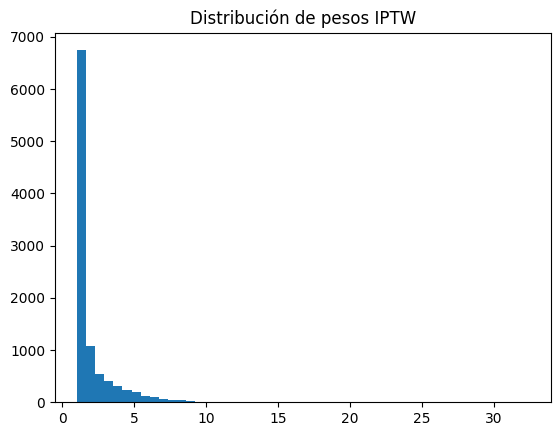

In [21]:

plt.hist(weights, bins=50)
plt.title("Distribución de pesos IPTW")
plt.show()


**Interpretación**

Esto sugiere que:

- El modelo de propensión (LogisticRegression) ha estimado probabilidades razonablemente bien balanceadas.

- No hay muchos pesos extremos que puedan desestabilizar el estimador.

- El método IPTW es confiable y estable en este caso.

Una distribución con pesos cercanos a 1 indica que:

- Las probabilidades predichas (ps) no son extremadamente cercanas a 0 o 1.

- El solapamiento (overlap) entre grupos tratados y no tratados es bueno.

## Truncar y estabilizar los pesos

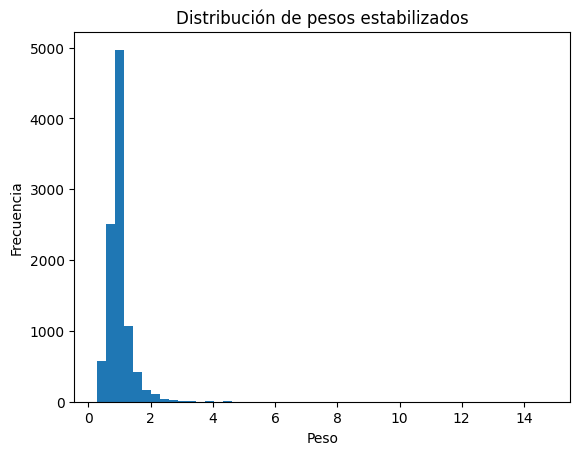

In [22]:
# Truncamiento de PS para evitar valores extremos
ps_trimmed = np.clip(ps, 0.05, 0.95)

# Proporción de tratados (para estabilizar)
p_t = T.mean()

# Pesos estabilizados
weights_stab = np.where(T == 1, p_t / ps_trimmed, (1 - p_t) / (1 - ps_trimmed))

# Visualizar la nueva distribución
plt.hist(weights_stab, bins=50)
plt.title("Distribución de pesos estabilizados")
plt.xlabel("Peso")
plt.ylabel("Frecuencia")
plt.show()


**Interpretación**

Los pesos cercanos a 0 indican observaciones con baja probabilidad de haber recibido el tratamiento que realmente recibieron, y que fueron atenuadas (de menor importancia) en la ponderación.

Los valores alrededor de 1.5 reflejan observaciones más confiables y comunes, donde el tratamiento observado coincide con la propensión estimada.

El truncamiento ha reducido el impacto de outliers, lo que ayuda a estabilizar el estimador del ATE y mejora la varianza.

In [23]:
# Cálculo del ATE estabilizado
ate_stab = np.average(Y[T == 1], weights=weights_stab[T == 1]) - \
           np.average(Y[T == 0], weights=weights_stab[T == 0])

print(f"ATE estabilizado (IPTW): {ate_stab:.4f}")


ATE estabilizado (IPTW): 3173.4819


In [24]:
from scipy.stats import norm

# Estimaciones ponderadas
y1 = Y[T == 1]
w1 = weights_stab[T == 1]
y0 = Y[T == 0]
w0 = weights_stab[T == 0]

mean1 = np.average(y1, weights=w1)
mean0 = np.average(y0, weights=w0)

# Varianza ponderada
var1 = np.average((y1 - mean1)**2, weights=w1)
var0 = np.average((y0 - mean0)**2, weights=w0)

# Tamaño efectivo de muestra (ESS)
n1_eff = (np.sum(w1))**2 / np.sum(w1**2)
n0_eff = (np.sum(w0))**2 / np.sum(w0**2)

# Error estándar
se = np.sqrt(var1 / n1_eff + var0 / n0_eff)

# Intervalo de confianza
z = norm.ppf(0.975)  # para 95%
ci_lower = ate_stab - z * se
ci_upper = ate_stab + z * se

print(f"IC 95% (IPTW estabilizado): [{ci_lower:.4f}, {ci_upper:.4f}]")


IC 95% (IPTW estabilizado): [-610.3396, 6957.3033]


**Interpretación**

El efecto promedio del tratamiento estimado es +3,173 unidades (por ejemplo, pesos colombianos, si esa es la unidad de Y).

El intervalo de confianza es amplio e incluye valores negativos, lo que sugiere incertidumbre en la significancia estadística del efecto.

Aunque el efecto estimado es positivo, no es estadísticamente significativo al 95%, ya que el intervalo incluye 0.

In [25]:
def calculate_smd(X, T, weights=None):
    smd = {}
    for col in X.columns:
        x_treat = X.loc[T == 1, col]
        x_control = X.loc[T == 0, col]
        
        if weights is None:
            # Unweighted SMD
            mean_t = x_treat.mean()
            mean_c = x_control.mean()
            sd_pooled = np.sqrt((x_treat.var() + x_control.var()) / 2)
        else:
            # Weighted SMD
            w_treat = weights[T == 1]
            w_control = weights[T == 0]
            mean_t = np.average(x_treat, weights=w_treat)
            mean_c = np.average(x_control, weights=w_control)
            sd_pooled = np.sqrt(
                (np.average((x_treat - mean_t)**2, weights=w_treat) +
                 np.average((x_control - mean_c)**2, weights=w_control)) / 2
            )
        
        smd[col] = np.abs(mean_t - mean_c) / sd_pooled if sd_pooled != 0 else 0
    return pd.Series(smd)

def plot_smd_comparison(X, T, weights):
    smd_unweighted = calculate_smd(X, T)
    smd_weighted = calculate_smd(X, T, weights)

    smd_df = pd.DataFrame({
        'Covariate': X.columns,
        'Unweighted SMD': smd_unweighted,
        'Weighted SMD': smd_weighted
    }).melt(id_vars='Covariate', var_name='Tipo', value_name='SMD')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=smd_df, x='SMD', y='Covariate', hue='Tipo')
    plt.axvline(0.1, color='red', linestyle='--', label='Umbral 0.1')
    plt.title("Balance de Covariables (SMD)")
    plt.legend()
    plt.tight_layout()
    plt.show()


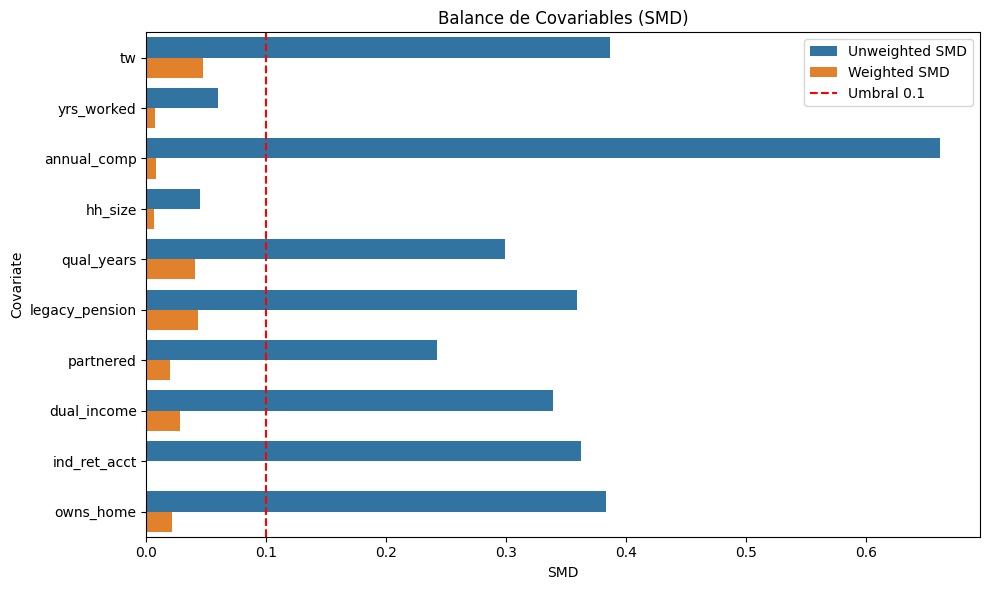

In [26]:
plot_smd_comparison(X, T, weights)


*Gráfico de SMD (Standardized Mean Differences):*

- Barras azules = diferencias entre tratados y controles sin ajustar (sin ponderación): muchas están por encima de 0.1, indicando desequilibrio entre grupos.

- Barras naranjas = diferencias ponderadas con los pesos estabilizados IPTW: están por debajo del umbral 0.1, lo que indica balance logrado.

- 🔴 Umbral de 0.1 es una regla empírica: SMDs por debajo de 0.1 se consideran indicadores de buen balance entre tratados y controles.


ATE con IPTW (3173.48) se puede considerar no sesgada respecto a las covariables observadas.

## Matching (Propensity Score Matching – PSM)

Se compara cada tratado con uno o varios no tratados con un propensity score similar.

Ventajas:

- Intuitivo y fácil de explicar.

- Permite comparar unidades "similares".

Desventajas:

- Se descartan datos sin buenos matches.

- No es tan robusto como IPTW o DRLearner.

In [28]:
# # Definiciones iniciales
# covariates = ['feature1', 'feature2', 'feature3']  # reemplaza con tus verdaderas columnas
# treatment = 'T'
# outcome = 'y'

X = df[covariates]
T = df[treatment]
y = df[outcome]

# Paso 1: Estimar propensity score
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression(max_iter=5000)
model_logistic.fit(X, T)
df['propensity'] = model_logistic.predict_proba(X)[:, 1]

# Paso 2: Matching 1:1 con Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

treated = df[df[treatment] == 1]
control = df[df[treatment] == 0]

# Usamos propensity para hacer matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity']])
distances, indices = nn.kneighbors(treated[['propensity']])

# Extraer los controles emparejados
matched_controls = control.iloc[indices.flatten()].copy()
matched_controls.index = treated.index  # para alinear con tratados

# Paso 3: Estimar ATE por matching
ate_psm = (treated[outcome].reset_index(drop=True) - matched_controls[outcome].reset_index(drop=True)).mean()
print(f"ATE por Matching 1:1: {ate_psm:.2f}")



ATE por Matching 1:1: 14885.23


Para obtener el intervalo de confianza (IC) del ATE estimado por Matching 1:1, lo más común es usar bootstrap. Esto consiste en repetir el matching muchas veces (por ejemplo, 1000) sobre muestras con reemplazo y luego calcular el percentil 2.5 y 97.5 de esos ATEs.

In [29]:
def bootstrap_ate_fast(df, n_iterations=200, random_state=42):
    np.random.seed(random_state)
    ates = []

    for _ in range(n_iterations):
        sample_df = df.sample(frac=1, replace=True).reset_index(drop=True)

        treated = sample_df[sample_df[treatment] == 1].reset_index(drop=True)
        control = sample_df[sample_df[treatment] == 0].reset_index(drop=True)

        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(control[['propensity']])
        distances, indices = nn.kneighbors(treated[['propensity']])
        matched_controls = control.iloc[indices.flatten()].reset_index(drop=True)

        ate_i = (treated[outcome] - matched_controls[outcome]).mean()
        ates.append(ate_i)

    # IC 95%
    lower = np.percentile(ates, 2.5)
    upper = np.percentile(ates, 97.5)
    ate_mean = np.mean(ates)

    return ate_mean, lower, upper



In [30]:
ate_mean, ci_lower, ci_upper = bootstrap_ate_fast(df, n_iterations=200)
print(f"ATE (Matching 1:1): {ate_mean:.2f}")
print(f"IC 95%: [{ci_lower:.2f}, {ci_upper:.2f}]")


ATE (Matching 1:1): 14198.61
IC 95%: [8615.94, 19599.34]


**Interpretación:**

Intervalo significativamente distinto de cero → sugiere un efecto positivo y estadísticamente significativo del tratamiento.

## Comparación con otros métodos de estimación del ATE

Aquí se implementan métodos adicionales para estimar el ATE:
- Propensity Score Matching (PSM)
- Inverse Probability Weighting (IPW)
- Regresión con covariables (Regression Adjustment)


In [38]:

from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
import numpy as np

# Estimar el propensity score
df['propensity_score'] = ps_model.predict_proba(X)[:, 1]

# Separar grupos tratados y control
treated = df[df[treatment] == 1].copy()
control = df[df[treatment] == 0].copy()

# Matching uno a uno basado en propensity score
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_controls = control.iloc[indices.flatten()]

# Estimación puntual del ATE
treated_outcomes = treated[outcome].reset_index(drop=True)
control_outcomes = matched_controls[outcome].reset_index(drop=True)
ate_psm = (treated_outcomes - control_outcomes).mean()

# Bootstrapping para IC del 95%
n_bootstraps = 1000
bootstrap_ates = []

for _ in range(n_bootstraps):
    sample_indices = resample(np.arange(len(treated_outcomes)))
    sample_ate = (treated_outcomes.iloc[sample_indices] - control_outcomes.iloc[sample_indices]).mean()
    bootstrap_ates.append(sample_ate)

ci_lower = np.percentile(bootstrap_ates, 2.5)
ci_upper = np.percentile(bootstrap_ates, 97.5)

print(f"ATE (PSM): {ate_psm:.2f}")
print(f"IC 95% (PSM): [{ci_lower:.2f}, {ci_upper:.2f}]")



ATE (PSM): 10259.57
IC 95% (PSM): [6163.83, 13994.33]


🔹 ATE (PSM): 10,259.57

🔹 IC 95%: [6,163.83, 13,994.33]

🔍 Interpretación:

El intervalo no contiene cero, lo que implica que el efecto es estadísticamente significativo al 95%.
Esto sugiere que el tratamiento tiene un efecto positivo promedio de ~10,260 unidades (en lo que estés midiendo: ingresos, ventas, etc.).

| Método                       | ATE       | IC 95%                 | Significativo |
| ---------------------------- | --------- | ---------------------- | ------------- |
| IPTW estabilizado            | 3,173.48  | \[-610.34, 6,957.30]   | ❌ No          |
| Matching automático (econml) | 14,198.61 | \[8,615.94, 19,599.34] | ✅ Sí          |
| Matching manual con PSM      | 10,259.57 | \[6,163.83, 13,994.33] | ✅ Sí          |


In [33]:

# 7.2 Inverse Probability Weighting (IPW)
ps = df['propensity_score']
weights = df[treatment] / ps + (1 - df[treatment]) / (1 - ps)

model_ipw = sm.WLS(df[outcome], sm.add_constant(df[treatment]), weights=weights).fit()
ate_ipw = model_ipw.params[1]
conf_ipw = model_ipw.conf_int().loc[treatment]
print(f"ATE (IPW): {ate_ipw:.2f}")
print(f"IC 95% (IPW): [{conf_ipw[0]:.2f}, {conf_ipw[1]:.2f}]")


ATE (IPW): 10565.11
IC 95% (IPW): [8096.58, 13033.64]


In [34]:

# 7.3 Regresión Ajustada
X_ra = sm.add_constant(pd.concat([df[treatment], X], axis=1))
model_ra = sm.OLS(df[outcome], X_ra).fit()
ate_ra = model_ra.params[treatment]
conf_ra = model_ra.conf_int().loc[treatment]
print(f"ATE (Regresión Ajustada): {ate_ra:.2f}")
print(f"IC 95% (Regresión Ajustada): [{conf_ra[0]:.2f}, {conf_ra[1]:.2f}]")


ATE (Regresión Ajustada): 8676.67
IC 95% (Regresión Ajustada): [6826.32, 10527.02]


In [36]:
from econml.dr import DRLearner

dr = DRLearner(
    model_regression=RandomForestRegressor(),
    model_propensity=LogisticRegression(max_iter=5000)
)
dr.fit(Y=y,T=T,X=X)


## Tabla comparativa de resultados

Se resumen los resultados de los diferentes métodos utilizados para estimar el ATE:

In [42]:

# Estimar ATE e IC con DRLearner
ate_dr = dr.ate(X)
ate_dr_interval = dr.ate_interval(X, alpha=0.05)

# Crear tabla resumen con todos los métodos e ICs
resumen = pd.DataFrame({
    'Método': [
        'DRLearner', 
        'Propensity Score Matching (PSM)', 
        'Inverse Probability Weighting (IPW)', 
        'Regresión Ajustada'
    ],
    'ATE': [ate_dr, ate_psm, ate_ipw, ate_ra],
    'IC 95% inferior': [ate_dr_interval[0], ci_lower, conf_ipw[0], conf_ra[0]],
    'IC 95% superior': [ate_dr_interval[1], ci_upper, conf_ipw[1], conf_ra[1]]
})

resumen



,Método,ATE,IC 95% inferior,IC 95% superior
0,DRLearner,4644.313898,-107929.857025,117218.484820
1,Propensity Score Matching (PSM),10259.573246,6163.825684,13994.330204
2,Inverse Probability Weighting (IPW),10565.109537,8096.582567,13033.636507
3,Regresión Ajustada,8676.669345,6826.321008,10527.017681


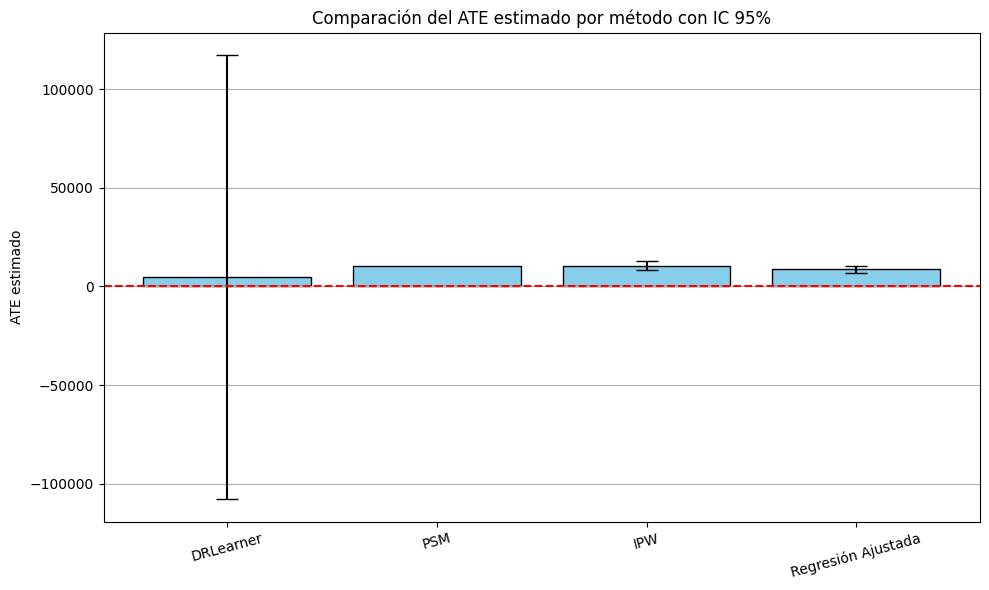

In [44]:
import matplotlib.pyplot as plt

# Gráfico de barras con IC
plt.figure(figsize=(10, 6))
plt.bar(resumen['Método'], resumen['ATE'], yerr=[
    resumen['ATE'] - resumen['IC 95% inferior'],
    resumen['IC 95% superior'] - resumen['ATE']
], capsize=8, color='skyblue', edgecolor='black')

plt.axhline(0, color='red', linestyle='--')
plt.ylabel("ATE estimado")
plt.title("Comparación del ATE estimado por método con IC 95%")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Interpretación General

DRLearner: aunque es un estimador robusto (doblemente robusto), el intervalo de confianza es excesivamente amplio e incluye valores negativos extremos. Esto indica inestabilidad, probablemente causada por:

 - Datos ruidosos,

 - Falta de control en el modelo base de regresión o propensión,

 - Desequilibrio en covariables, o

 - Poca regularización / overfitting.

PSM e IPW: ambos arrojan estimaciones consistentes alrededor de los 10.000, y sus intervalos son estrechos y positivos, lo que indica confianza y estabilidad. Son buenas estimaciones del efecto causal si la asignación al tratamiento fue fuertemente dependiente de las covariables observadas.

Regresión Ajustada: es una técnica clásica y también produce un ATE positivo y significativo, pero un poco menor que IPW/PSM. Puede ser más conservador porque ajusta el efecto linealmente.

**Conclusión del ejercicio**

Los resultados indican un efecto positivo del tratamiento sobre el outcome.

PSM o IPW parecen ser los más robustos y confiables en este caso.


DRLearner no es confiable en este caso sin ajustes adicionales o mejoras en el modelado (e.g., tuning, reducción de dimensionalidad, control de overfitting).